# DO APERTURE PHOTOMETRY FOR A SINGLE STAR

In [ ]:
## load Libraires
import numpy as np
import os
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import astropy.units as u
from astropy.table import Table
from scipy import interpolate
from shapely.geometry import LineString, Point
from astropy.stats import sigma_clipped_stats
import requests,io
!pip install photutils
from photutils.aperture import aperture_photometry, CircularAnnulus, CircularAperture

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 8.3 MB/s eta 0:00:00


Blue


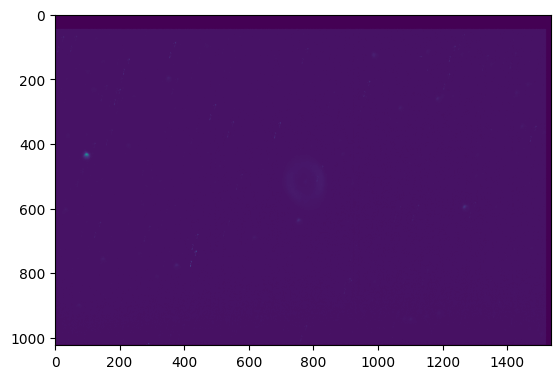

Green


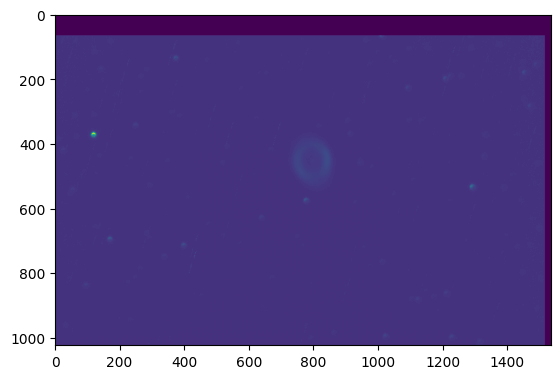

Red


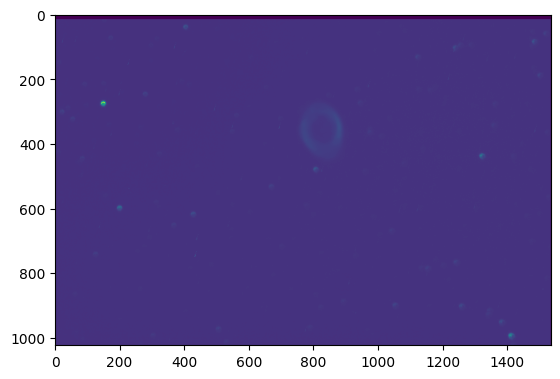

In [ ]:
## Load image
filtros={
         'Blue':{'fits1':[],'head':[],'image':[], 'pos_guess':[],'img':[],'position':[],'phot_table':[],'y':[],'phot_table':[],
                 'threshold':[],'segment_img':[],'srcmask':[],'bkg':[],'erimage':[],'low':[],'up':[],'aperture':[],'norm':[],'flux':[],'error':[]},

         'Green':{'fits1':[],'head':[],'image':[], 'pos_guess':[],'img':[],'position':[],'phot_table':[],'y':[],'phot_table':[],
                  'threshold':[],'segment_img':[],'srcmask':[],'bkg':[],'erimage':[],'low':[],'up':[],'aperture':[],'norm':[],'flux':[],'error':[]},

         'Red':{'fits1':[],'head':[],'image':[], 'pos_guess':[],'img':[],'position':[],'phot_table':[],'y':[],'phot_table':[],
                'threshold':[],'segment_img':[],'srcmask':[],'bkg':[],'erimage':[],'low':[],'up':[],'aperture':[],'norm':[],'flux':[],'error':[]}}

dir="/content/sample_data/"
base_filename = "m57_"
end_filename = "_mask_combined"
for k,v in filtros.items():
  filtros[k]['fits1'] = fits.open(dir+ f"{base_filename}{k}{end_filename}.fits")
  filtros[k]['head'] = filtros[k]['fits1'][0].header
  filtros[k]['image'] = filtros[k]['fits1'][0].data
  plt.imshow(filtros[k]['image'])
  print(k)
  plt.show()


Get noise image (background and Poisson error)

In [ ]:
## First mask sources
from photutils.segmentation import detect_threshold, detect_sources
from photutils.utils import circular_footprint
from astropy.stats import SigmaClip # Added this import statement
from photutils import Background2D,MedianBackground
from astropy.stats import SigmaClip
from photutils.utils import calc_total_error

for k,v in filtros.items():
  sigma_clip = SigmaClip(sigma=3.0)
  filtros[k]['threshold'] = detect_threshold(filtros[k]['image'], nsigma=2.0, sigma_clip=sigma_clip)
  filtros[k]['segment_img'] = detect_sources(filtros[k]['image'], filtros[k]['threshold'], npixels=10)
  footprint = circular_footprint(radius=10)

  filtros[k]['srcmask'] = filtros[k]['segment_img'].make_source_mask(footprint=footprint)
  #plt.imshow(filtros[k]['srcmask'])
  #plt.show()

  ## Get background image with sources masked

  sigma_clip = SigmaClip(sigma=3.0)
  bkg_estimator = MedianBackground()
  filtros[k]['bkg'] = Background2D(filtros[k]['image'],(50,50),filter_size=(3,3),sigma_clip=sigma_clip,  ## this is the background and its noise
                    bkg_estimator=bkg_estimator,mask=filtros[k]['srcmask'])
  filtros[k]['erimage'] = calc_total_error(filtros[k]['image']-filtros[k]['bkg'].background, filtros[k]['bkg'].background_rms, 1.5)  ## this is the Poisson error added to background noise

<ipython-input-5-c67a4520619a>:5: DeprecationWarning: `photutils.Background2D` is a deprecated alias for `photutils.background.Background2D` and will be removed in the future. Instead, please use `from photutils.background import Background2D` to silence this warning.
  from photutils import Background2D,MedianBackground
<ipython-input-5-c67a4520619a>:5: DeprecationWarning: `photutils.MedianBackground` is a deprecated alias for `photutils.background.MedianBackground` and will be removed in the future. Instead, please use `from photutils.background import MedianBackground` to silence this warning.
  from photutils import Background2D,MedianBackground


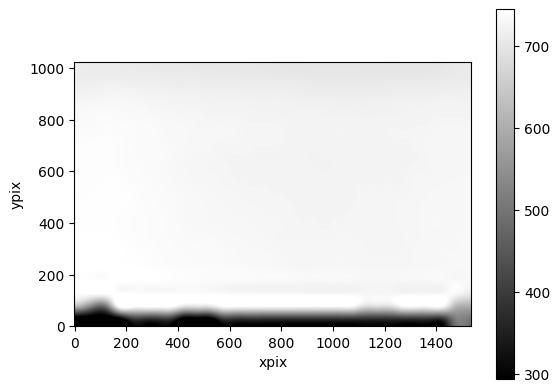

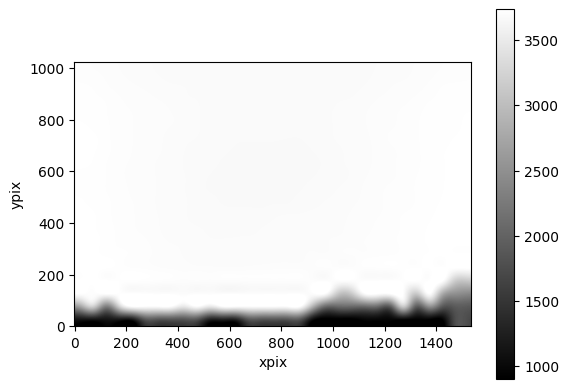

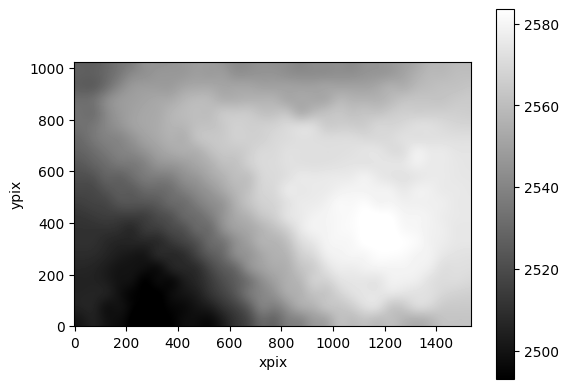

In [ ]:
## Background
for k,v in filtros.items():
  filtros[k]['lo'],filtros[k]['up'] = np.percentile(filtros[k]['bkg'].background,1),np.percentile(filtros[k]['bkg'].background,99) ## Use filtros[k]['bkg'].background to access the background data
  plt.figure()
  plt.imshow(filtros[k]['bkg'].background,cmap='gray',origin='lower',clim=(filtros[k]['lo'],filtros[k]['up']))
  plt.colorbar()
  plt.xlabel('xpix')
  plt.ylabel('ypix')
  dic={'black','blue','green','red'}


Blue
Blue


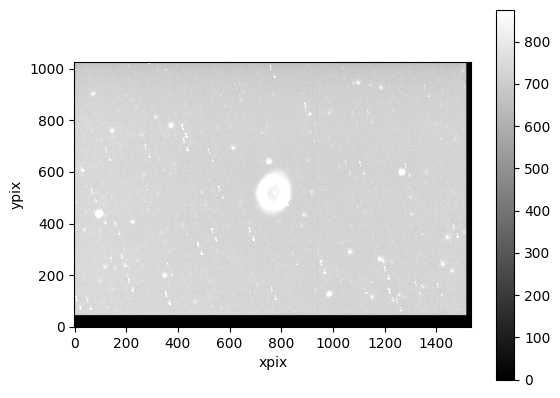

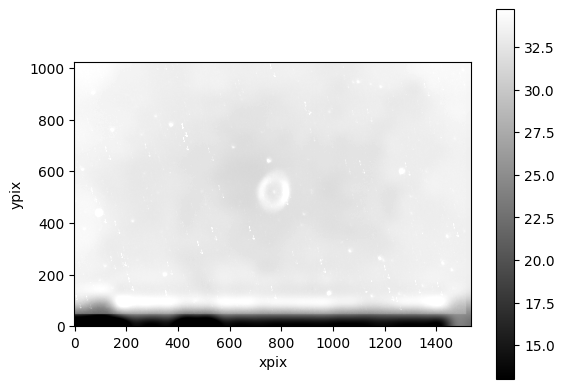

Green
Green


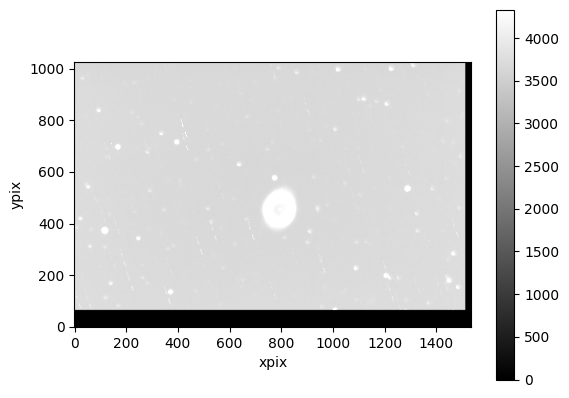

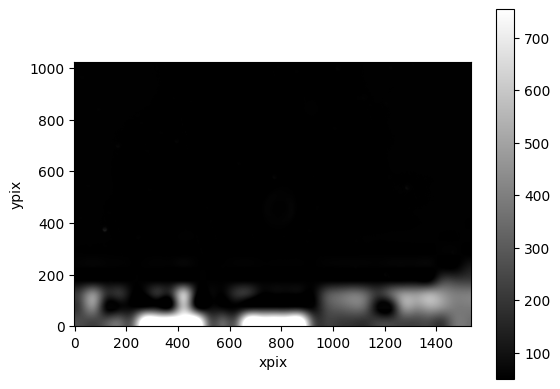

Red
Red


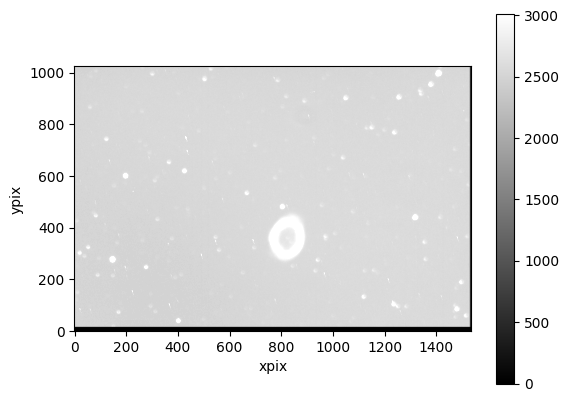

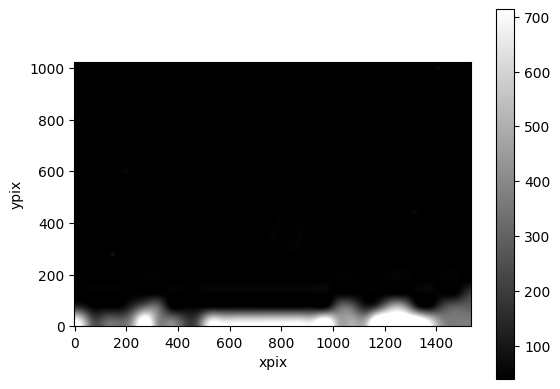

In [ ]:
## Image and noise Plot
for k,v in filtros.items():
  print(k)
  filtros[k]['lo'],filtros[k]['up'] = np.percentile(filtros[k]['image'],1),np.percentile(filtros[k]['image'],99)
  plt.figure()
  plt.imshow(filtros[k]['image'],cmap='gray',origin='lower',clim=(filtros[k]['lo'],filtros[k]['up']))
  plt.colorbar()
  plt.xlabel('xpix')
  plt.ylabel('ypix')
  print(k)
  plt.figure()
  filtros[k]['lo'],filtros[k]['up'] = np.percentile(filtros[k]['erimage'],1),np.percentile(filtros[k]['erimage'],99)
  plt.imshow(filtros[k]['erimage'],cmap='gray',origin='lower',clim=(filtros[k]['lo'],filtros[k]['up']))
  plt.colorbar()
  plt.xlabel('xpix')
  plt.ylabel('ypix')
  plt.show()

## Get central position of star with initial guess

Blue


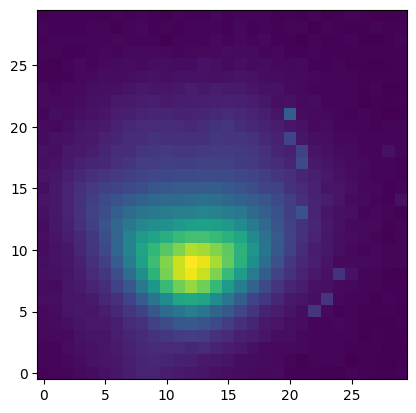

[ 98.23617702 437.64354383]
Green


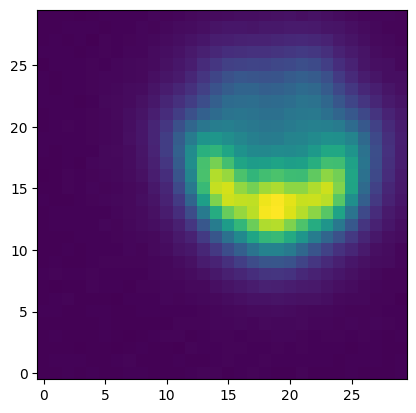

[116.40332799 370.42097254]
Red


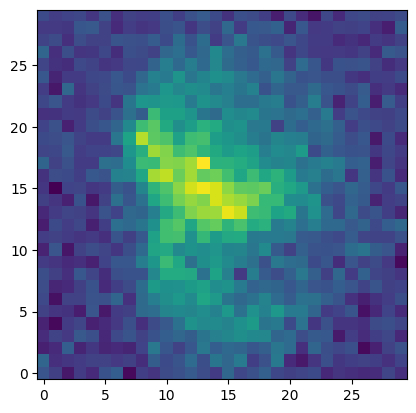

[972.49550265 362.50428915]


In [ ]:
## Estimate position with an initial position guess of the star with centroid
#filtros['black']['pos_guess'] = [784,570]   ## initial guess (x,y) (CHANGE TO YOUR STAR POSITION!)
filtros['Blue']['pos_guess'] = [100,440]
filtros['Red']['pos_guess'] = [973,363]
filtros['Green']['pos_guess'] = [115,370]
from photutils.centroids import centroid_com, centroid_2dg  #load centroid libraries
for k,v in filtros.items():
  #if k!='blue':
    filtros[k]['img'] = filtros[k]['image'][filtros[k]['pos_guess'][1]-15:filtros[k]['pos_guess'][1]+15,filtros[k]['pos_guess'][0]-15:filtros[k]['pos_guess'][0]+15]#select subportion of 60x60 image
    print(k)
    plt.imshow(filtros[k]['img'],origin='lower')
    plt.show()
    filtros[k]['position'] = centroid_com(filtros[k]['img'])+filtros[k]['pos_guess']-[15,15]
    print(filtros[k]['position'])
#blue

#filtros['blue']['img'] = filtros['blue']['image'][filtros['blue']['pos_guess'][1]-15:filtros['blue']['pos_guess'][1]+15,filtros['blue']['pos_guess'][0]-15:filtros['blue']['pos_guess'][0]+15]#select subportion of 60x60 image
#print('blue')
#plt.imshow(filtros['blue']['img'],origin='lower')
#plt.show()
#filtros['blue']['position'] = centroid_com(filtros[k]['img'])+filtros['blue']['pos_guess']-[15,15]
#print(filtros['blue']['position'])

Do aperture photometry

Blue
 id      xcenter           ycenter      ...  aperture_sum_21  aperture_sum_err_21
           pix               pix        ...                                      
--- ----------------- ----------------- ... ----------------- -------------------
  1 98.23617702249369 437.6435438263024 ... 919552.9888928172    1634.01746850169
[ 329.59387614  438.65109866  542.83768879  638.77394898  723.78854019
  797.95353702  863.35591731  922.62674464  977.53195668 1030.01323704
 1080.47611731 1129.97443182 1179.06891092 1228.03588093 1276.97325197
 1326.28258646 1376.1817006  1426.72778749 1477.75548565 1529.27366082
 1581.32724247 1634.0174685 ]
Blue
Green
 id      xcenter            ycenter      ...  aperture_sum_21   aperture_sum_err_21
           pix                pix        ...                                       
--- ------------------ ----------------- ... ------------------ -------------------
  1 116.40332798617851 370.4209725424464 ... 2896911.1055735582  2638.4162354969912
[ 626.

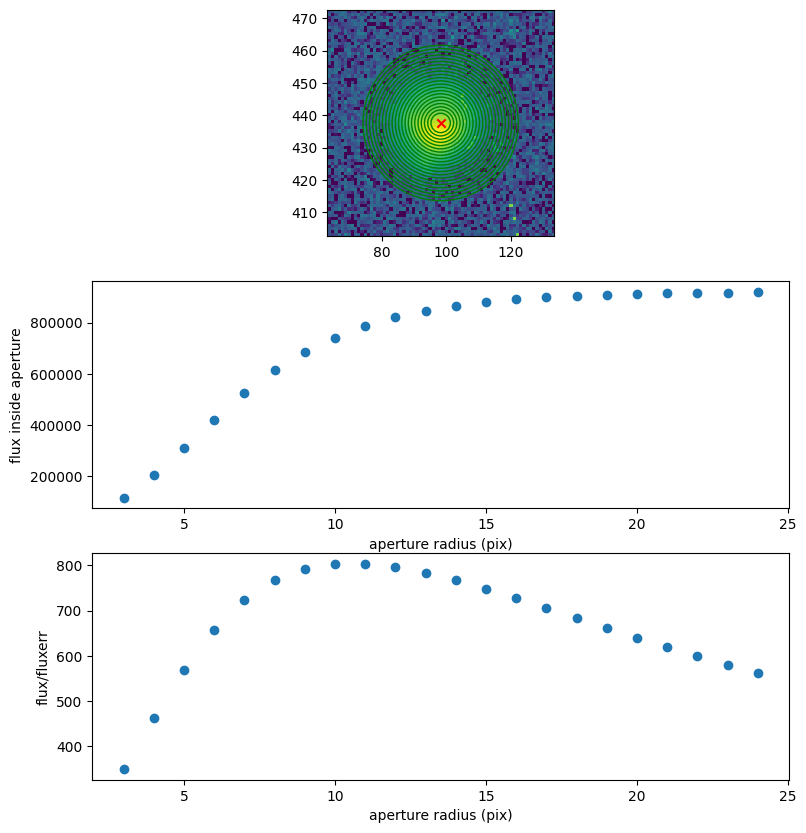

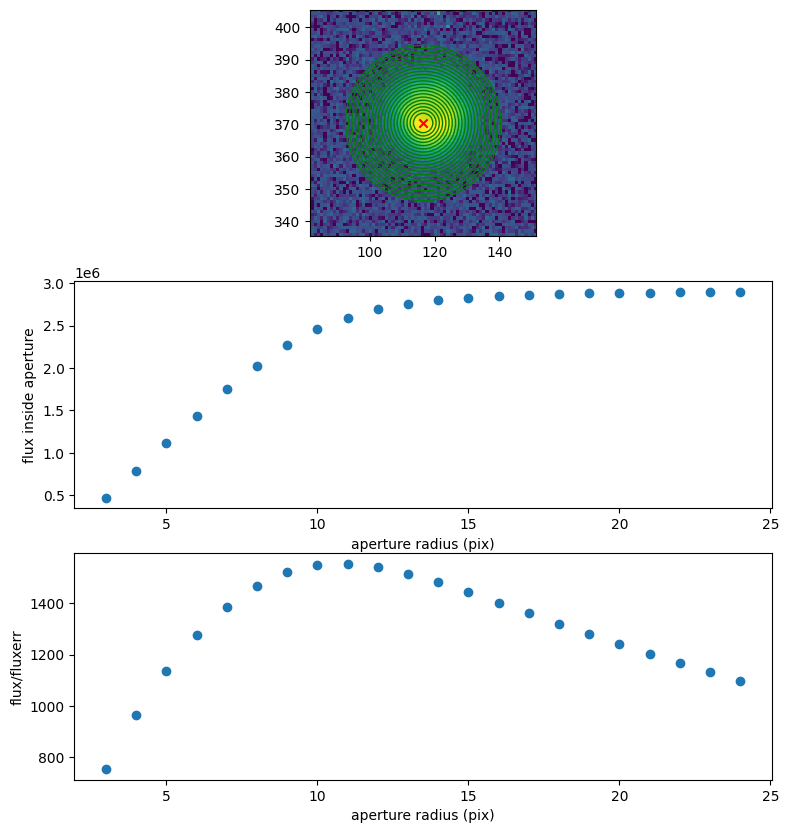

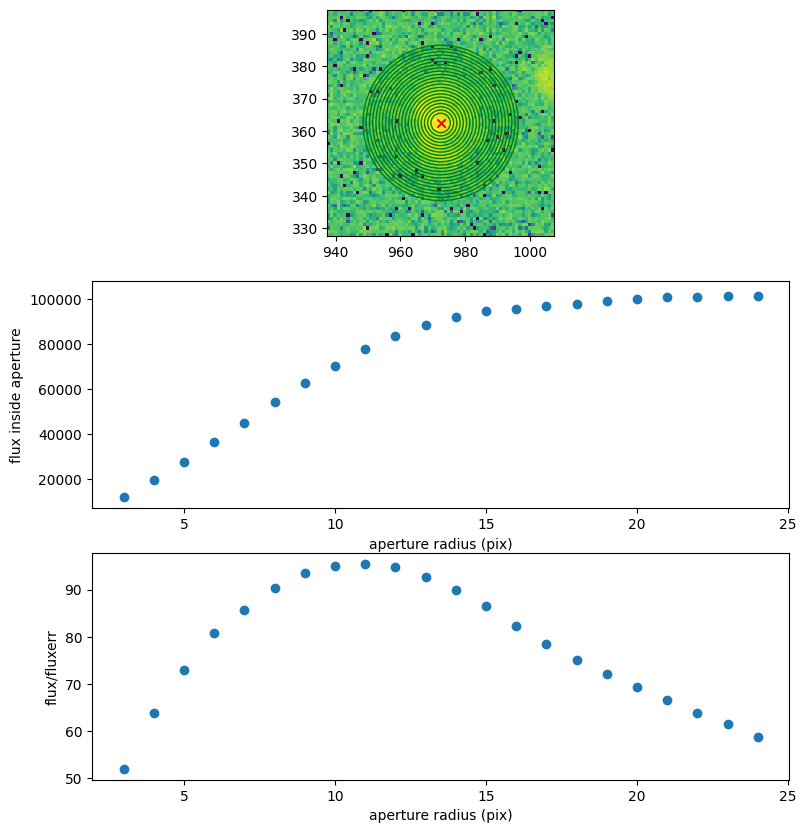

In [ ]:
## Get several apertures for one star position (you could have more positions)
from photutils.aperture import CircularAperture
from astropy.visualization import simple_norm

for k,v in filtros.items():
  print(k)
  radii = np.arange(3,25)  # radii (pix) of circular apertures
  filtros[k]['aperture'] = [CircularAperture(filtros[k]['position'], r=r) for r in radii] # define circular apertures

  ## Perform aperture photometry (sum of all pixels within aperture) SUBTRACTING first background found previously
  filtros[k]['phot_table'] = aperture_photometry(filtros[k]['image']-filtros[k]['bkg'].background, filtros[k]['aperture'],error=filtros[k]['erimage'])
  print(filtros[k]['phot_table'])  ## print table
  filtros[k]['y'] = np.asarray([filtros[k]['phot_table']['aperture_sum_'+str(i)] for i in np.arange(0,radii.size)],dtype=float)
  filtros[k]['ery'] = np.asarray([filtros[k]['phot_table']['aperture_sum_err_'+str(i)] for i in np.arange(0,radii.size)],dtype=float)
  filtros[k]['y']=np.reshape(filtros[k]['y'], (len(filtros[k]['y']),))
  filtros[k]['ery']=np.reshape(filtros[k]['ery'], (len(filtros[k]['ery']),))
  print(filtros[k]['ery'])

  ## Plot both: curve growth and image with apertures
  print(k)
  fig,ax = plt.subplots(3,figsize=(9,10))
  filtros[k]['norm'] = simple_norm(filtros[k]['img'],'log',percent=99.)
  ax[0].imshow(filtros[k]['image'],norm=filtros[k]['norm'],cmap='viridis', aspect=1, interpolation='nearest')
  ax[0].scatter(filtros[k]['position'][0],filtros[k]['position'][1],color='red',marker='x')
  for r in radii:
    circle = plt.Circle(filtros[k]['position'],r,color='green',fill=False)
    ax[0].add_artist(circle)
  ax[0].set_xlim([filtros[k]['position'][0]-35,filtros[k]['position'][0]+35])
  ax[0].set_ylim([filtros[k]['position'][1]-35,filtros[k]['position'][1]+35])
  # plot curve of growth
  ax[1].errorbar(radii,filtros[k]['y'],yerr=filtros[k]['ery'],fmt='o')
  ax[1].set_xlabel('aperture radius (pix)')
  ax[1].set_ylabel('flux inside aperture')
  # plot flux/fluxerr (S/N)
  ax[2].errorbar(radii,filtros[k]['y']/filtros[k]['ery'],fmt='o')
  ax[2].set_xlabel('aperture radius (pix)')
  ax[2].set_ylabel('flux/fluxerr')


In [ ]:

for k,v in filtros.items():
## Final flux and error at a given radius. All stars in the same image should have SAME radius
  radius = 15 # (CHANGE TO YOUR RADIUS!) -choose radius (here large radius since curve of growth is nice -it has an asymptotic value- but if not take a smaller radius where S/N is high, i.e ~16 in this example)
  filtros[k]['flux'] = filtros[k]['y'][np.round(radii) == np.round(radius)]
  filtros[k]['error'] = filtros[k]['ery'][np.round(radii) == np.round(radius)]
  print("    Star flux (counts): %f +/- %f" %(filtros[k]['flux'],filtros[k]['error']))

# Check if the keyword exists in the header.
#if 'EXPTIME' in head:
 #   print("    Star flux (counts) per second: %f +/- %f" %(flux/head['EXPTIME'],error/head['EXPTIME']))
#else:
    # Print the available keywords
  #  print(f"Available keywords: {head.keys()}")
    # Suggest a possible alternative if it exists
 #   if 'EXPOSURE' in head:
  #      print(f"Did you mean 'EXPOSURE'?")

    Star flux (counts): 882058.854837 +/- 1179.068911
    Star flux (counts): 2829250.127169 +/- 1961.533778
    Star flux (counts): 94383.132560 +/- 1091.886728


<ipython-input-31-36ba42b59e4d>:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("    Star flux (counts): %f +/- %f" %(filtros[k]['flux'],filtros[k]['error']))


**Associar contagens com o fluxo real**

Black


In [ ]:
'''#show the counts
#print(f'Número total de contagens por segundo: {flux/0.2}')
#sheliak magnitude
mag=3.45
fluxo=10**(mag/2.5)
#flux_cont=fluxo*0.2/flux
#print(f'O fluxo por contagem é: {flux_cont}')
#ts=0.1
#tm=320

Kn=fluxo/filtros['black']['flux']#*ts/tm
print(f'K Black é: {Kn}')'''

K Black é: [1.89117491e-09]


Blue


In [ ]:
#show the counts
#print(f'Número total de contagens por segundo: {filtros['blue']['flux']/0.2}')
#sheliak magnitude
mag=11.55
fluxo=10**(mag/2.5)
#flux_cont=fluxo*0.2/flux
#print(f'O fluxo por contagem Blue é: {flux_cont}')
#ts=1.1
#tm=570

Kb=fluxo/filtros['Blue']['flux']#*ts/tm
print(f'K Blue é: {Kb}')

K Blue é: [0.04726095]


Green


In [ ]:
#show the counts
#print(f'Número total de contagens por segundo: {filtros['green']['flux']/0.2}')
#sheliak magnitude
mag=	10.97
fluxo=10**(mag/2.5)
#flux_cont=fluxo*0.2/flux
#print(f'O fluxo por contagem Green é: {flux_cont}')
#ts=1.1
#tm=630

Kg=fluxo/filtros['Green']['flux']#*ts/tm
print(f'K Green é: {Kg}')

K Green é: [0.00863632]


Red



In [ ]:
#show the counts
#print(f'Número total de contagens por segundo: {filtros['red']['flux']/0.2}')
#sheliak magnitude
mag1=15.02
mag2=15.69
fluxo=10**(mag1/2.5) + 10**(mag2/2.5)
#flux_cont=fluxo*0.2/flux
#print(f'O fluxo por contagem Red é: {flux_cont}')
#ts=1.1
#tm=270

Kr=fluxo/filtros['Red']['flux']#*ts/tm
print(f'K Red é: {Kr}')

K Red é: [30.79557394]


Valores de K

In [ ]:
print(f'K Red é: {Kr}')
print(f'K Green é: {Kg}')
print(f'K Blue é: {Kb}')
#print(f'K Black é: {Kn}')

K Red é: [0.00090996]
K Green é: [8.24762024e-06]
K Blue é: [2.64546753e-05]
